In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial
import os

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data as data

from torchvision.datasets import MNIST
import torchvision.transforms as tf

import pyro
import pyro.distributions as dist
import pyro.infer.autoguide as ag

import tyxe

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
N_TASKS = 3
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
NUM_TEST_SAMPLES = 10
NUM_EPOCHS = 5
INIT_SD = 1e-1

DATA_PATH = os.path.join(os.environ.get("DATASETS_PATH", "./data"), "mnist")

DOWNSAMPLE = False
FLAT_SIZE = 49 if DOWNSAMPLE else 784
IMG_SHAPE = (7, 7) if DOWNSAMPLE else (28, 28)

In [4]:
def make_pmnist(downsample=False):
    transforms = []
    if downsample:
        transforms.append(tf.Resize((7, 7)))
    permutation = torch.randperm(784 if not downsample else 49)
    transforms += [tf.ToTensor(), tf.Lambda(lambda x: x.flatten()[permutation])]
    transform = tf.Compose(transforms)
    train_set = MNIST(DATA_PATH, train=True, transform=transform, download=True)
    train_loader = data.DataLoader(train_set, TRAIN_BATCH_SIZE, shuffle=True)
    test_set = MNIST(DATA_PATH, train=False, transform=transform)
    test_loader = data.DataLoader(test_set, TEST_BATCH_SIZE)
    
    return train_loader, test_loader, permutation

In [5]:
train_loader, test_loader, permutation = make_pmnist(DOWNSAMPLE)

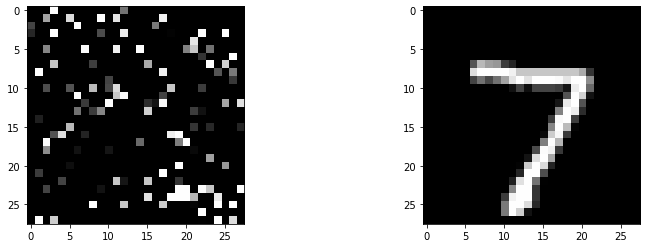

In [6]:
inv_perm = torch.empty(FLAT_SIZE).long()
inv_perm[permutation] = torch.arange(FLAT_SIZE)
imgs, _ = next(iter(test_loader))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ax1.imshow(imgs[0].view(IMG_SHAPE), cmap="gray")
ax2.imshow(imgs[0][inv_perm].view(IMG_SHAPE), cmap="gray")

In [7]:
def make_net():
    return nn.Sequential(
        nn.Linear(FLAT_SIZE, 100), nn.ReLU(inplace=True),
        nn.Linear(100, 100), nn.ReLU(inplace=True),
        nn.Linear(100, 10))

In [8]:
observation_model = tyxe.likelihoods.Categorical(len(train_loader.sampler))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
var_bnn = tyxe.VariationalBNN(make_net(), prior, observation_model,
                              net_guide_builder=partial(tyxe.guides.AutoNormal,
                                                        init_loc_fn=tyxe.guides.init_to_normal_radford,
                                                        init_scale=INIT_SD)
                             )

In [9]:
train_loaders, test_loaders, _ = zip(*[make_pmnist(DOWNSAMPLE) for _ in range(N_TASKS)])

In [10]:
def train(bnn, train_loader, optim=None, local_reparam=True):
    if optim is None:
        optim = pyro.optim.Adam({"lr": 1e-3})
    
    tq = tqdm(total=NUM_EPOCHS)
    def callback(*args):
        tq.update()
    
    if local_reparam:
        with tyxe.poutine.local_reparameterization():
            bnn.fit(train_loader, optim, NUM_EPOCHS, callback=callback)
    else:
        bnn.fit(train_loader, optim, NUM_EPOCHS, callback=callback)

In [11]:
def test(bnn, test_loader):
    return sum(bnn.evaluate(x, y, NUM_TEST_SAMPLES)[0] for x, y in iter(test_loader)) / len(test_loader.sampler)

In [12]:
def full_run(bnn, train_loaders, test_loaders, callback=None, local_reparam=True):
    pyro.clear_param_store()
    test_errs = torch.zeros(len(train_loaders), len(train_loaders))
    for i in range(len(train_loaders)):
        train(bnn, train_loaders[i], local_reparam=local_reparam)
        for j in range(i+1):
            test_errs[j, i] = test(bnn, test_loaders[j]).item()
        
        if callback is not None:
            callback(bnn)
            
    return test_errs

In [13]:
var_errs = full_run(var_bnn, train_loaders, test_loaders,
                    lambda bnn: bnn.update_prior(tyxe.priors.DictPrior(
                        bnn.net_guide.get_detached_distributions(tyxe.util.pyro_sample_sites(bnn.net)))))
var_errs

tensor([[0.0409, 0.1314, 0.2894],
        [0.0000, 0.0716, 0.1075],
        [0.0000, 0.0000, 0.0658]])

In [14]:
def plot(errs):
    for task_id, e in enumerate(errs):
        plt.plot(range(task_id, len(e)), e[task_id:], marker="o", label=f"Task {task_id}")
    plt.xlabel("TASK")
    plt.xticks(range(len(errs)))
    plt.ylabel("test error")
    plt.ylim(0, 1)
    plt.legend()

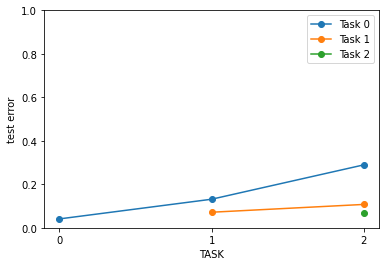

In [15]:
plot(var_errs)

In [16]:
pyro.clear_param_store()
det_bnn = tyxe.VariationalBNN(make_net(), prior, observation_model, net_guide_builder=ag.AutoDelta)
det_errs = full_run(det_bnn, train_loaders, test_loaders, local_reparam=False)

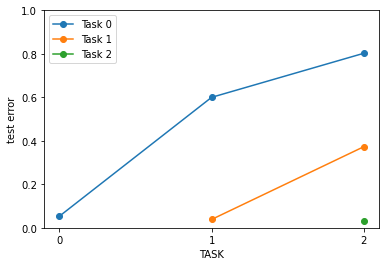

In [17]:
plot(det_errs)

In [18]:
def avg(errs):
    return errs.sum(0) / errs.gt(0.).float().sum(0)

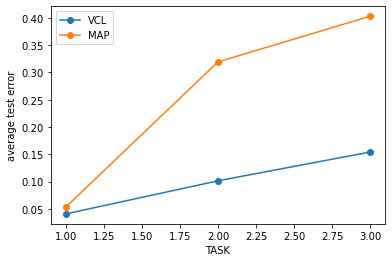

In [19]:
plt.plot(range(1, N_TASKS+1), avg(var_errs), marker="o", label="VCL")
plt.plot(range(1, N_TASKS+1), avg(det_errs), marker="o", label="MAP")
plt.xlabel("TASK")
plt.ylabel("average test error")
plt.legend()